In [1]:
#!pip install geneticalgorithm

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import csv
from keras import models
from keras import layers
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering
from geneticalgorithm import geneticalgorithm as ga
from matplotlib import pyplot as plt

## Rough Set Flow Graph (RSFG)

In [68]:
def get_rsfg(sis):
    
    num_cols = sis.shape[1]

    rsfg_columns = ["level", "relation", "support", "certainty", "coverage", "strength"]

    rsfg_df = pd.DataFrame(columns=rsfg_columns)

    for level in range(num_cols - 1):
        
        edge_counts = {}
        source_counts = {}
        target_counts = {}
        total_possible = len(sis.iloc[:, level + 1])
        
        for _, row in sis.iterrows():
            
            source = str(row.iloc[level])
            target = str(row.iloc[level + 1])
            key = (source, target)
            edge_counts[key] = edge_counts.get(key, 0) + 1
            source_counts[source] = source_counts.get(source, 0) + 1
            target_counts[target] = target_counts.get(target, 0) + 1
            
        for (source, target), count in edge_counts.items():
            
            cer = count / source_counts[source] if source_counts[source] else 0
            cov = count / target_counts[target] if target_counts[target] else 0
            str_value = count / total_possible if total_possible else 0
            lev = f"{level}<>{level+1}"
            rel = f"{source}-->{target}"
            
            new_row = pd.DataFrame(data=np.array([[lev, rel, count, f"{cer:.6f}", f"{cov:.6f}", f"{str_value:.6f}"]]), columns=rsfg_columns)
            
            rsfg_df = pd.concat([rsfg_df, new_row], ignore_index=True)

    return rsfg_df

## Data (MNIST)

In [3]:
(x_train_valid, y_train_valid), (x_test, y_test) = mnist.load_data()
x_train, x_valid, y_train, y_valid = train_test_split(x_train_valid, y_train_valid, test_size=0.2, stratify=y_train_valid)

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_valid = x_valid.reshape((x_valid.shape[0], x_valid.shape[1], x_valid.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_test = x_test.astype('float32')

x_train = x_train/255.0
x_valid = x_valid/255.0
x_test = x_test/255.0

y_train = tf.keras.utils.to_categorical(y_train)
y_valid = tf.keras.utils.to_categorical(y_valid)
y_test = tf.keras.utils.to_categorical(y_test)

## Model (unreadable)

In [7]:
n_filters_conv_1 = 4
filter_size_conv_1 = 5
n_filters_conv_2 = 4
filter_size_conv_2 = 5
n_neurons_dense_1 = 50
n_neurons_dense_2 = 10

n_epochs = 20
batch_size = 16

In [8]:
model = models.Sequential()
model.add(layers.Conv2D(n_filters_conv_1, (filter_size_conv_1, filter_size_conv_1), activation='relu', input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3])))
model.add(layers.Conv2D(n_filters_conv_2, (filter_size_conv_2, filter_size_conv_2), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(n_neurons_dense_1, activation='relu'))
model.add(layers.Dense(n_neurons_dense_2, activation='softmax'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 4)      │           104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 20, 20, 4)      │           404 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │        80,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,068 (316.67 KB)

 Trainable params: 81,068 (316.67 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = model.fit(x_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(x_valid, y_valid), verbose=0)

In [12]:
layer_outputs = [layer.output for layer in model.layers[:5]]
activation_model = models.Model(inputs=model.layers[0].input, outputs=layer_outputs)

In [13]:
activations = activation_model.predict(x=x_train)

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 870us/step


In [14]:
artifact_clusters = pd.DataFrame()

In [15]:
for f in range(n_filters_conv_1):

    print('filter: '+str(f))

    activations_f = activations[0][:,:,:,f]
    activations_f = activations_f.reshape([activations_f.shape[0],activations_f.shape[1]*activations_f.shape[2]])
    ac_f = AgglomerativeClustering(n_clusters=4).fit(activations_f)

    artifact_clusters['l0_f'+str(f)] = ac_f.labels_

filter: 0
filter: 1
filter: 2
filter: 3


In [16]:
print(artifact_clusters)

       l0_f0  l0_f1  l0_f2  l0_f3
0          1      3      0      3
1          2      0      0      2
2          3      3      0      3
3          2      2      1      0
4          2      0      2      0
...      ...    ...    ...    ...
47995      2      0      0      2
47996      0      1      0      0
47997      1      1      3      1
47998      2      0      0      2
47999      1      3      0      3

[48000 rows x 4 columns]


In [17]:
for f in range(n_filters_conv_2):

    print('filter: '+str(f))

    activations_f = activations[1][:,:,:,f]
    activations_f = activations_f.reshape([activations_f.shape[0],activations_f.shape[1]*activations_f.shape[2]])
    ac_f = AgglomerativeClustering(n_clusters=4).fit(activations_f) 

    artifact_clusters['l1_f'+str(f)] = ac_f.labels_

filter: 0
filter: 1
filter: 2
filter: 3


In [18]:
print(artifact_clusters)

       l0_f0  l0_f1  l0_f2  l0_f3  l1_f0  l1_f1  l1_f2  l1_f3
0          1      3      0      3      1      0      2      2
1          2      0      0      2      0      3      2      2
2          3      3      0      3      1      1      1      0
3          2      2      1      0      2      0      3      3
4          2      0      2      0      3      0      0      1
...      ...    ...    ...    ...    ...    ...    ...    ...
47995      2      0      0      2      1      3      2      2
47996      0      1      0      0      1      1      1      3
47997      1      1      3      1      0      0      1      0
47998      2      0      0      2      0      3      2      2
47999      1      3      0      3      1      1      1      0

[48000 rows x 8 columns]


In [19]:
activations_d_1 = activations[3]
ac_d = AgglomerativeClustering(n_clusters=10).fit(activations_d_1)
artifact_clusters['l3'] = ac_d.labels_

In [22]:
print(artifact_clusters)

       l0_f0  l0_f1  l0_f2  l0_f3  l1_f0  l1_f1  l1_f2  l1_f3  l3
0          1      3      0      3      1      0      2      2   4
1          2      0      0      2      0      3      2      2   5
2          3      3      0      3      1      1      1      0   4
3          2      2      1      0      2      0      3      3   9
4          2      0      2      0      3      0      0      1   2
...      ...    ...    ...    ...    ...    ...    ...    ...  ..
47995      2      0      0      2      1      3      2      2   5
47996      0      1      0      0      1      1      1      3   0
47997      1      1      3      1      0      0      1      0   3
47998      2      0      0      2      0      3      2      2   5
47999      1      3      0      3      1      1      1      0   4

[48000 rows x 9 columns]


In [23]:
predictions = model.predict(x=x_train)
pred = np.argmax(predictions, axis=1)

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 650us/step


In [24]:
artifact_clusters['p'] = pred

In [25]:
print(artifact_clusters)

       l0_f0  l0_f1  l0_f2  l0_f3  l1_f0  l1_f1  l1_f2  l1_f3  l3  p
0          1      3      0      3      1      0      2      2   4  2
1          2      0      0      2      0      3      2      2   5  6
2          3      3      0      3      1      1      1      0   4  3
3          2      2      1      0      2      0      3      3   9  4
4          2      0      2      0      3      0      0      1   2  1
...      ...    ...    ...    ...    ...    ...    ...    ...  .. ..
47995      2      0      0      2      1      3      2      2   5  6
47996      0      1      0      0      1      1      1      3   0  5
47997      1      1      3      1      0      0      1      0   3  0
47998      2      0      0      2      0      3      2      2   5  6
47999      1      3      0      3      1      1      1      0   4  3

[48000 rows x 10 columns]


## Twin (readable)

In [26]:
sis = pd.DataFrame()

In [27]:
sis['conv1'] = artifact_clusters.astype(str).loc[:,['l0_f0', 'l0_f1', 'l0_f2', 'l0_f3']].apply('_'.join, axis=1)

In [28]:
sis['conv2'] = artifact_clusters.astype(str).loc[:,['l1_f0', 'l1_f1', 'l1_f2', 'l1_f3']].apply('_'.join, axis=1)

In [29]:
sis['dense1'] = artifact_clusters['l3']

In [30]:
sis['output'] = artifact_clusters['p']

In [31]:
print(sis)

         conv1    conv2  dense1  output
0      1_3_0_3  1_0_2_2       4       2
1      2_0_0_2  0_3_2_2       5       6
2      3_3_0_3  1_1_1_0       4       3
3      2_2_1_0  2_0_3_3       9       4
4      2_0_2_0  3_0_0_1       2       1
...        ...      ...     ...     ...
47995  2_0_0_2  1_3_2_2       5       6
47996  0_1_0_0  1_1_1_3       0       5
47997  1_1_3_1  0_0_1_0       3       0
47998  2_0_0_2  0_3_2_2       5       6
47999  1_3_0_3  1_1_1_0       4       3

[48000 rows x 4 columns]


In [69]:
rsfg = get_rsfg(sis)

In [70]:
print(rsfg)

     level           relation support certainty  coverage  strength
0     0<>1  1_3_0_3-->1_0_2_2       6  0.002112  0.002078  0.000125
1     0<>1  2_0_0_2-->0_3_2_2    2307  0.523011  0.971368  0.048063
2     0<>1  3_3_0_3-->1_1_1_0    2187  0.553951  0.389979  0.045562
3     0<>1  2_2_1_0-->2_0_3_3    2496  0.615233  0.592593  0.052000
4     0<>1  2_0_2_0-->3_0_0_1    4634  0.903842  0.984910  0.096542
...    ...                ...     ...       ...       ...       ...
2959  2<>3              1-->3       6  0.001310  0.001223  0.000125
2960  2<>3              4-->7       1  0.000201  0.000200  0.000021
2961  2<>3              5-->3       1  0.000209  0.000204  0.000021
2962  2<>3              1-->2       1  0.000218  0.000210  0.000021
2963  2<>3              6-->6       1  0.000207  0.000211  0.000021

[2964 rows x 6 columns]


In [74]:
rsfg['confidence'] = 2*rsfg['certainty'].astype(float)*rsfg['coverage'].astype(float)/(rsfg['certainty'].astype(float)+rsfg['coverage'].astype(float))

In [75]:
print(rsfg)

     level           relation support certainty  coverage  strength  \
0     0<>1  1_3_0_3-->1_0_2_2       6  0.002112  0.002078  0.000125   
1     0<>1  2_0_0_2-->0_3_2_2    2307  0.523011  0.971368  0.048063   
2     0<>1  3_3_0_3-->1_1_1_0    2187  0.553951  0.389979  0.045562   
3     0<>1  2_2_1_0-->2_0_3_3    2496  0.615233  0.592593  0.052000   
4     0<>1  2_0_2_0-->3_0_0_1    4634  0.903842  0.984910  0.096542   
...    ...                ...     ...       ...       ...       ...   
2959  2<>3              1-->3       6  0.001310  0.001223  0.000125   
2960  2<>3              4-->7       1  0.000201  0.000200  0.000021   
2961  2<>3              5-->3       1  0.000209  0.000204  0.000021   
2962  2<>3              1-->2       1  0.000218  0.000210  0.000021   
2963  2<>3              6-->6       1  0.000207  0.000211  0.000021   

      confidence  
0       0.002095  
1       0.679929  
2       0.457723  
3       0.603701  
4       0.942636  
...          ...  
2959    0.0012

In [77]:
levels = rsfg['level'].unique()
print(levels)

['0<>1' '1<>2' '2<>3']


In [ ]:
rsfg_layers = list()
node_dicts = list()

for level in levels:

    layer = rsfg.loc[rsfg['level']==level,:]
    layer[['source', 'target']] = layer['relation'].str.split('-->', expand=True)

    if len(node_dicts)==0:
        
        node_dict_1 = {key: i for i, key in enumerate(layer['source'].unique())}
        node_dicts.append(node_dict_1)

        layer['source_id'] = layer['source'].map(node_dict_1)

    else:

        layer['source_id'] = layer['source'].map(node_dicts[-1])        

    node_dict_2 = {key: i for i, key in enumerate(layer['target'].unique())}
    node_dicts.append(node_dict_2)

    layer['target_id'] = layer['target'].map(node_dict_2)
    
    layer = layer[['source_id', 'target_id', 'source', 'target', 'confidence']]
        
    rsfg_layers.append(layer)

## Genetic Algorithm

https://pypi.org/project/geneticalgorithm/

In [92]:
def fitness(x):

    confidences = list()

    for i in range(len(x)-1):

        layer = rsfg_layers[i]

        confidence = layer.loc[(layer['source_id']==x[i]) & (layer['target_id']==x[i+1]), ['confidence']]

        if len(confidence)==0:

            return 0
            
        confidences.append(confidence['confidence'])

    return -np.min(np.array(confidences))  

[[0, 190], [0, 190], [0, 9], [0, 9]]
 The best solution found:                                                                           
 [54. 27.  8.  8.]

 Objective function:
 -0.1197874840552118


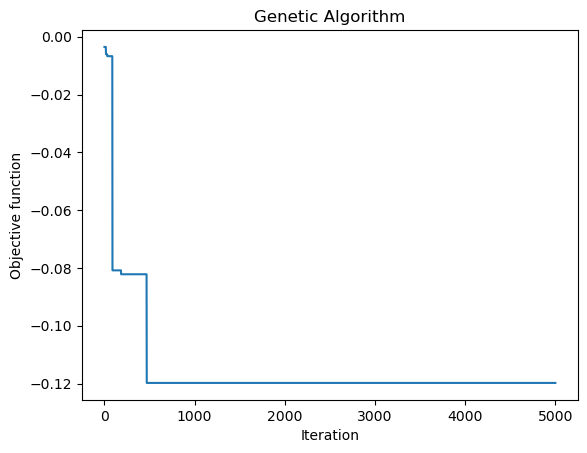

In [93]:
parameters = {'max_num_iteration': 5000,
              'population_size': 20,
              'parents_portion': 0.3,
              'mutation_probability':0.1,
              'crossover_probability': 0.1,
              'elit_ratio': 0.01,
              'crossover_type':'uniform',
              'max_iteration_without_improv': None}


varbounds = []

for d in node_dicts:

    varbounds.append([0,len(d)-1])

print(varbounds)

gen_alg = ga(function=fitness, dimension=len(varbounds), variable_type='int', variable_boundaries=np.array(varbounds), algorithm_parameters=parameters)

gen_alg.run()

In [94]:
best_path = gen_alg.output_dict['variable']

In [110]:
best_path_info = pd.DataFrame(columns=['confidence', 'source', 'target'])

for i in range(len(best_path)-1):

        layer = rsfg_layers[i]

        path_info = layer.loc[(layer['source_id']==best_path[i]) & (layer['target_id']==best_path[i+1]), ['confidence', 'source', 'target']]
    
        best_path_info = pd.concat([best_path_info.dropna(axis=1, how='all') , path_info], ignore_index=True)

print(best_path_info)

   confidence   source   target
0    0.149326  0_3_0_1  1_0_1_3
1    0.119787  1_0_1_3        8
2    0.972864        8        8


## Visualization

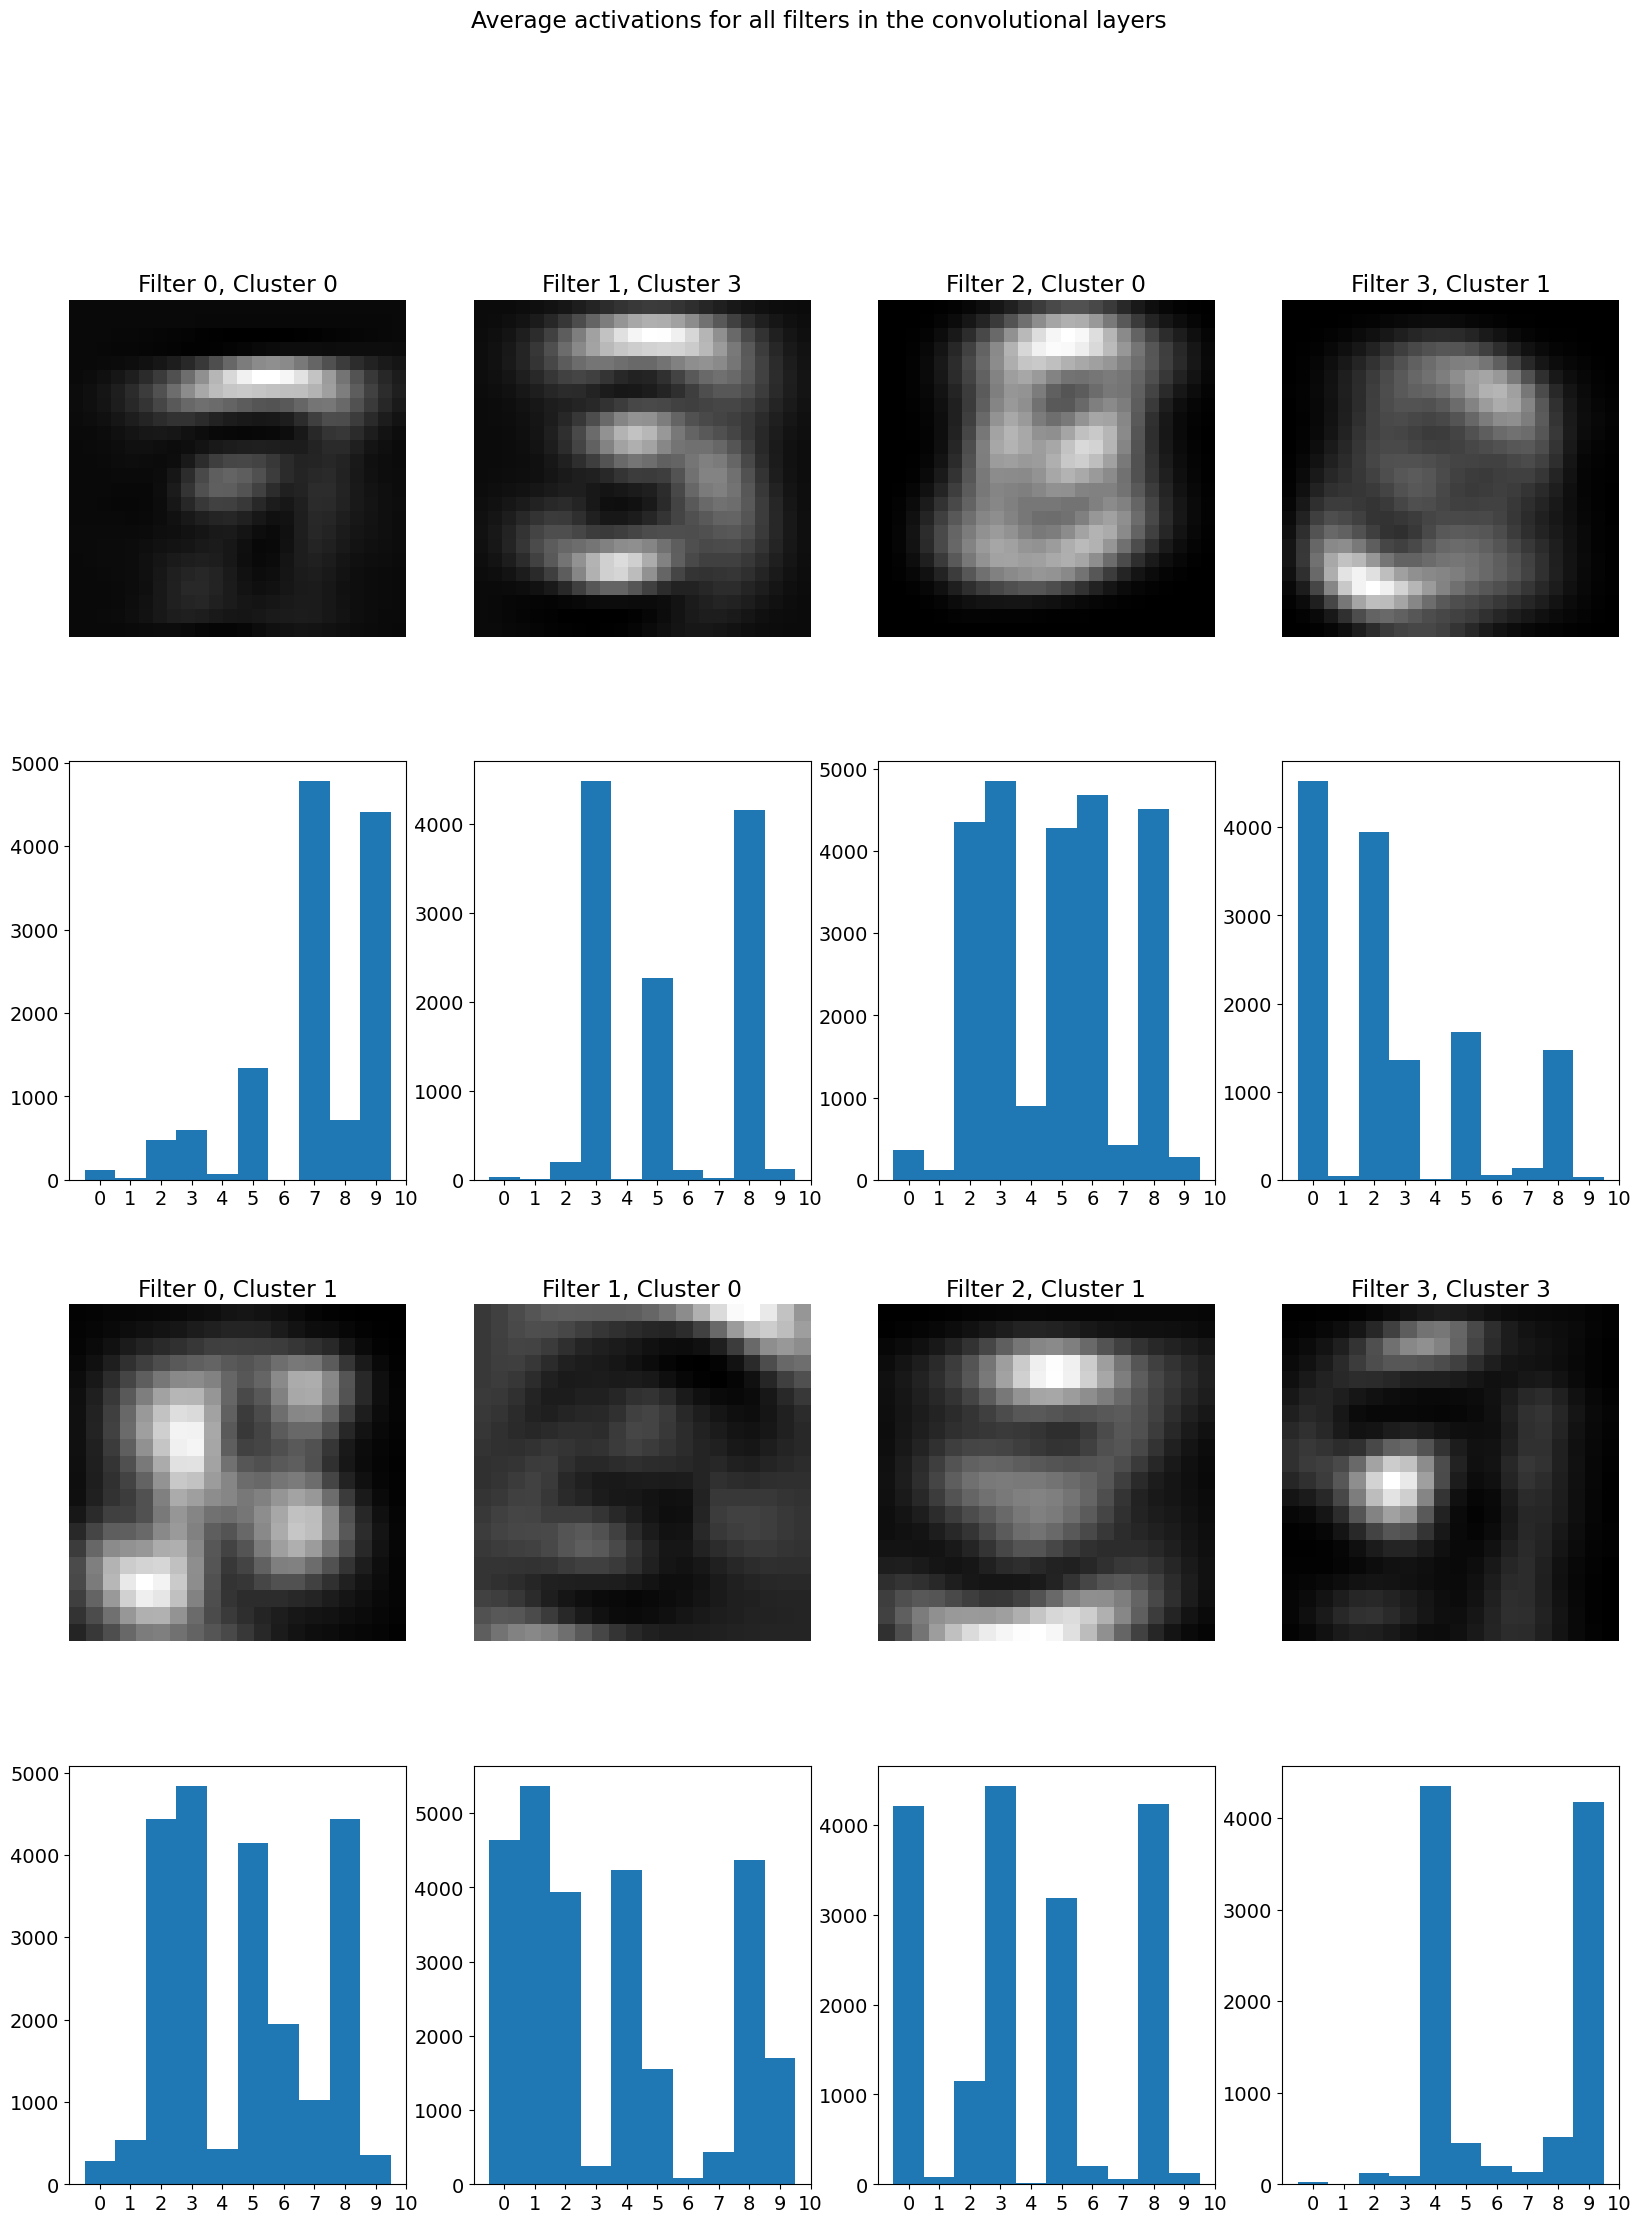

In [120]:
plt.rcParams.update({'font.size': 14})

fig, axes = plt.subplots(4, 4, figsize=(20, 25)) 
fig.suptitle("Average activations for all filters in the convolutional layers")

source_cluster_indexes = best_path_info.loc[:,'source'].str.split('_')
target_cluster_indexes = best_path_info.loc[:,'target'].str.split('_')

row = 0

for filter_index in range(4):

    source_cluster_index = int(source_cluster_indexes[0][filter_index])
    target_cluster_index = int(target_cluster_indexes[0][filter_index])
    
    activation_data_0 = activations[0][artifact_clusters[f'l0_f{filter_index}'] == source_cluster_index, :, :, filter_index]
    cluster_0 = artifact_clusters.loc[artifact_clusters[f'l0_f{filter_index}'] == source_cluster_index, :]

    activation_data_1 = activations[1][artifact_clusters[f'l1_f{filter_index}'] == target_cluster_index, :, :, filter_index]
    cluster_1= artifact_clusters.loc[artifact_clusters[f'l1_f{filter_index}'] == target_cluster_index, :]

    average_activation_0 = np.mean(activation_data_0, axis=0)
    average_activation_1 = np.mean(activation_data_1, axis=0)

    col = filter_index
            
    axes[2*row, col].imshow(average_activation_0, cmap=plt.get_cmap('gray'))
    axes[2*row, col].axis("off")
    axes[2*row, col].set_title(f"Filter {filter_index}, Cluster {source_cluster_index}")

    bins = np.arange(0, 9 + 1.5) - 0.5
    axes[2*row+1, col].hist(cluster_0['p'], bins)
    axes[2*row+1, col].set_xticks(bins + 0.5)

    axes[2*row+2, col].imshow(average_activation_1, cmap=plt.get_cmap('gray'))
    axes[2*row+2, col].axis("off")
    axes[2*row+2, col].set_title(f"Filter {filter_index}, Cluster {target_cluster_index}")

    bins = np.arange(0, 9 + 1.5) - 0.5
    axes[2*row+3, col].hist(cluster_1['p'], bins)
    axes[2*row+3, col].set_xticks(bins + 0.5)

plt.show()

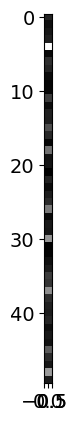

In [121]:
activation_data_3 = activations[3][artifact_clusters[f'l0_f{filter_index}'] == source_cluster_index, :]
activation_data_3 = np.mean(activation_data_3, axis=0)
plt.imshow(activation_data_3.reshape(activation_data_3.shape[0], 1, 1), cmap=plt.get_cmap('gray'))